In [1]:
!pip install --upgrade cvxpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install mosek

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from sklearn import linear_model
from scipy.optimize import curve_fit
from scipy.optimize import nnls
import cvxpy as cp
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
# import pwlf
import matplotlib.animation as animation
from matplotlib import rc


rc('animation', html='jshtml')

In [4]:
print(cp.__version__)

1.2.1


In [5]:
print(cp.installed_solvers())

['CVXOPT', 'ECOS', 'ECOS_BB', 'GLPK', 'GLPK_MI', 'MOSEK', 'OSQP', 'SCIPY', 'SCS']


# Setting and Hyperparameters

In [6]:
valuations = np.array([[0.50722067, 0.76313337, 0.05360443, 0.7501781,  0.67800042],
 [0.2274455,  0.06174344, 0.39171342, 0.1402779,  0.15473259],
 [0.16527965, 0.3476444,  0.36241701, 0.99000073, 0.75359852],
 [0.34999164, 0.68091931, 0.0310125,  0.17069236, 0.03813618],
 [0.02829523, 0.34238797, 0.69479688, 0.45690191, 0.4699344 ]])

valuations = valuations * 5

# Load Data

In [39]:
from google.colab import drive
drive.mount('/content/drive')

utility_type = "linear"
coef_hist_filename = f"/content/drive/My Drive/exp_results/jax_savings_big/coef_hist_{utility_type}_fisher.npy"
intercept_hist_filename = f"/content/drive/My Drive/exp_results/jax_savings_big/intercept_hist_{utility_type}_fisher.npy"
values_hist_filename = f"/content/drive/My Drive/exp_results/jax_savings_big/values_hist_{utility_type}_fisher.npy"
budgets_hist_filename = f"/content/drive/My Drive/exp_results/jax_savings_big/budgets_hist_{utility_type}_fisher.npy"

with open(coef_hist_filename, 'rb') as f:
    coef_hist_linear = np.load(f)
with open(intercept_hist_filename, 'rb') as f:
    intercept_hist_linear = np.load(f)
with open(values_hist_filename, 'rb') as f:
    values_hist_linear = np.load(f)
with open(budgets_hist_filename, 'rb') as f:
    budgets_hist_linear = np.load(f)


# utility_type = "leontief"
# coef_hist_filename = f"/content/drive/My Drive/exp_results/jax_savings/coef_hist_{utility_type}_fisher.npy"
# intercept_hist_filename = f"/content/drive/My Drive/exp_results/jax_savings/intercept_hist_{utility_type}_fisher.npy"
# values_hist_filename = f"/content/drive/My Drive/exp_results/jax_savings/values_hist_{utility_type}_fisher.npy"
# budgets_hist_filename = f"/content/drive/My Drive/exp_results/jax_savings/budgets_hist_{utility_type}_fisher.npy"

# with open(coef_hist_filename, 'rb') as f:
#     coef_hist_leontief = np.load(f)
# with open(intercept_hist_filename, 'rb') as f:
#     intercept_hist_leontief = np.load(f)
# with open(values_hist_filename, 'rb') as f:
#     values_hist_leontief = np.load(f)
# with open(budgets_hist_filename, 'rb') as f:
#     budgets_hist_leontief = np.load(f)


# utility_type = "cd"
# coef_hist_filename = f"/content/drive/My Drive/exp_results/jax_savings/coef_hist_{utility_type}_fisher.npy"
# intercept_hist_filename = f"/content/drive/My Drive/exp_results/jax_savings/intercept_hist_{utility_type}_fisher.npy"
# values_hist_filename = f"/content/drive/My Drive/exp_results/jax_savings/values_hist_{utility_type}_fisher.npy"
# budgets_hist_filename = f"/content/drive/My Drive/exp_results/jax_savings/budgets_hist_{utility_type}_fisher.npy"

# with open(coef_hist_filename, 'rb') as f:
#     coef_hist_cd = np.load(f)
# with open(intercept_hist_filename, 'rb') as f:
#     intercept_hist_cd = np.load(f)
# with open(values_hist_filename, 'rb') as f:
#     values_hist_cd = np.load(f)
# with open(budgets_hist_filename, 'rb') as f:
#     budgets_hist_cd = np.load(f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
print(coef_hist_linear[-1])
print(intercept_hist_linear[-1])

[2.32690902 1.44383133 2.55996584 2.10382669 1.9660408 ]
838.9806639344359


# Library

## utilities

In [9]:
################### Utility Functions ##########################

def get_linear_util(demands, valuations):
    util = np.sum(demands * valuations, axis = 1) 
    return util


def get_leontief_util(demands, valuations):
    util =  np.min(demands/valuations.clip(min = 0.001), axis = 1) 
    return util

def get_cd_util(demands, valuations):
    util = np.sum(np.log(demands.clip(min = 0.001))*valuations, axis = 1) 
    return util 

#################### Utility Gradient Functions #####################
def get_linear_util_gradient(allocations, valuations):
    return valuations

def get_leontief_util_gradient(allocations, valuations):
    grad_matrix = []
    argmins = np.argmin(allocations/valuations.clip(min = 0.001), axis = 0)
    marginal_utils = np.zeros(allocations.shape)
    
    for buyer in range(allocations.shape[0]):
      marginal_utils[buyer, argmins[buyer] ] = 1 / valuations[buyer, argmins[buyer]].clip(min = 0.001)
    
    return marginal_utils

def get_cd_util_gradient(allocations, valuations):
    # return ( np.prod(np.power(allocations, valuations), axis = 1)*( valuations / allocations.clip(min = 0.001) ).T).T
    return ( valuations / allocations.clip(min = 0.001) )


################### Min-Max Objective Functions ##########################

def get_linear_obj(prices, demands, budgets, valuations):
  utils = np.sum(valuations * demands, axis = 1)
  return np.sum(prices) + budgets @ np.log(utils.clip(min=0.0001))


def get_leontief_obj(prices, demands, budgets, valuations):
    utils = np.min(demands/valuations, axis = 1)
    return np.sum(prices) + budgets @ np.log(utils.clip(min=0.0001))


def get_cd_obj(prices, demands, budgets, valuations):
    utils = np.prod(np.power(demands, valuations), axis= 1)
    return np.sum(prices) + budgets @ np.log(utils.clip(min=0.0001))


### JAX

In [10]:
from jax import device_put
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

#### Linear

In [11]:
def get_linear_obj(prices, demands, budgets, valuations):
  utils = jnp.sum(valuations * demands, axis = 1)
  return jnp.sum(prices) + jnp.dot(budgets, jnp.log(utils.clip(0.001)))

def get_linear_value(prices, demands, savings, budgets, valuations, discount, value_coef, value_intercept):
  num_buyers = budgets.shape
  next_budgets = [savings * ir + jnp.ones(num_buyers) * 9.5 for ir in [0.9, 1.0, 1.1, 1.2, 1.5]]
  return get_linear_obj(prices, demands, budgets-savings, valuations) + jnp.sum(jnp.array([discount*(next_budget.T @ value_coef + value_intercept) for next_budget in next_budgets]))/5

prices = device_put(np.array([10.0,10.0, 10.0, 10.0, 10.0]))
demands = device_put(np.array([[2.0,2.1, 1.2, 1.3, 1.4],
                               [2.2,2.3,1.2, 1.3, 1.4],
                               [2.2,2.3,1.2, 1.3, 1.4],
                               [2.2,2.3,1.2, 1.3, 1.4],
                               [2.2,2.3,1.2, 1.3, 1.4]]))
budgets = device_put(np.array([10,10,10,10,10]))
savings = device_put(np.array([0.01,0.01,0.01,0.01,0.01]))
value_coef = device_put(np.repeat(1, 5))
value_intercept = 10.0

print(get_linear_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))


demands_grad_linear_value = grad(jit(get_linear_value), argnums=1)
savings_grad_linear_value = grad(jit(get_linear_value), argnums=2)
print("___________________JAX___________________")
print(demands_grad_linear_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))
print(savings_grad_linear_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))


spendings = budgets - savings
utils = get_linear_util(demands, valuations).clip(min = 0.01)
marginals = get_linear_util_gradient(demands, valuations)
demands_step = (((spendings/utils)*marginals.T)).T
savings_step = -np.log(utils) + 0.9*value_coef
print("___________________BY HAND___________________")
print(demands_step)
print(savings_step)

235.76363
___________________JAX___________________
[[1.1001688  1.6552472  0.11626878 1.6271471  1.4705926 ]
 [1.5033286  0.40810072 2.5890772  0.92718375 1.0227238 ]
 [0.4190575  0.8814333  0.91888845 2.5100925  1.9107076 ]
 [1.3200989  2.5682924  0.11697298 0.64381766 0.1438421 ]
 [0.0962974  1.1652519  2.364608   1.5549781  1.5993317 ]]
[-2.1107497 -0.9964962 -1.9546533 -1.5574698 -1.6602745]
___________________BY HAND___________________
[[1.1001688  1.6552472  0.11626878 1.6271471  1.4705926 ]
 [1.5033286  0.40810072 2.5890772  0.92718375 1.0227238 ]
 [0.4190575  0.8814333  0.91888845 2.5100925  1.9107076 ]
 [1.3200989  2.5682924  0.11697298 0.64381766 0.1438421 ]
 [0.0962974  1.1652519  2.364608   1.5549781  1.5993317 ]]
[-2.2367496 -1.1224962 -2.0806532 -1.6834699 -1.7862746]


#### Leontief

In [12]:
def get_leontief_obj(prices, demands, budgets, valuations):
  utils = jnp.min(demands/valuations, axis = 1) 
  return jnp.sum(prices) + jnp.dot(budgets, jnp.log(utils))

def get_leontief_value(prices, demands, savings, budgets, valuations, discount, value_coef, value_intercept):
  num_buyers = budgets.shape
  next_budgets = jnp.array([savings * ir + jnp.ones(num_buyers) * 9.5 for ir in [0.9, 1.0, 1.1, 1.2, 1.5]])
  return get_leontief_obj(prices, demands, budgets-savings, valuations) + jnp.sum(jnp.array([discount*(next_budget.T @ value_coef + value_intercept) for next_budget in next_budgets]))/5

prices = device_put(np.array([10.0,10.0, 10.0, 10.0, 10.0]))
demands = device_put(np.array([[2.0,2.1, 1.2, 1.3, 1.4],
                               [2.2,2.3,1.2, 1.3, 1.4],
                               [2.2,2.3,1.2, 1.3, 1.4],
                               [2.2,2.3,1.2, 1.3, 1.4],
                               [2.2,2.3,1.2, 1.3, 1.4]]))
budgets = device_put(np.array([10,10,10,10,10]))
savings = device_put(np.array([0.01,0.01,0.01,0.01,0.01]))
value_coef = device_put(np.repeat(1, 5))
value_intercept = 10.0

print(get_leontief_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))


demands_grad_leontief_value = grad(jit(get_leontief_value), argnums=1)
savings_grad_leontief_value = grad(jit(get_leontief_value), argnums=2)
print("___________________JAX___________________")
print(demands_grad_leontief_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))
print(savings_grad_leontief_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))

spendings = budgets - savings
utils = get_leontief_util(demands, valuations).clip(min = 0.01)
marginals = get_leontief_util_gradient(demands, valuations)
demands_step = (((spendings/utils)*marginals.T)).T
savings_step = -np.log(utils) + 0.9*value_coef
print("___________________BY HAND___________________")
print(demands_step)
print(savings_step)

58.42729
___________________JAX___________________
[[0.        0.        0.        7.6846156 0.       ]
 [0.        0.        8.325     0.        0.       ]
 [0.        0.        0.        7.6846156 0.       ]
 [0.        4.343478  0.        0.        0.       ]
 [0.        0.        8.324999  0.        0.       ]]
[2.085629  1.5158916 2.3630242 1.4182174 2.0889807]
___________________BY HAND___________________
[[11.365527   0.         0.         0.         0.       ]
 [14.337563   0.         0.         0.         0.       ]
 [ 0.         0.         0.         0.        10.0952635]
 [ 0.         0.        95.366646   0.         0.       ]
 [ 0.         0.         8.325      0.         0.       ]]
[1.959629  1.3898915 2.237024  1.2922174 1.9629805]


#### CD

In [13]:
def get_cd_obj(prices, demands, budgets, valuations):
  utils =jnp.prod(jnp.power(demands, valuations), axis= 1)
  return jnp.sum(prices) + jnp.dot(budgets, jnp.log(utils.clip(0.001)))

def get_cd_value(prices, demands, savings, budgets, valuations, discount, value_coef, value_intercept):
  num_buyers = budgets.shape
  next_budgets = jnp.array([savings * ir + jnp.ones(num_buyers) * 9.5 for ir in [0.9, 1.0, 1.1, 1.2, 1.5]])
  return get_cd_obj(prices, demands, budgets-savings, valuations) + jnp.sum(jnp.array([discount*(next_budget.T @ value_coef + value_intercept) for next_budget in next_budgets]))/5

prices = device_put(np.array([10.0,10.0, 10.0, 10.0, 10.0]))
demands = device_put(np.array([[2.0,2.1, 1.2, 1.3, 1.4],
                               [2.2,2.3,1.2, 1.3, 1.4],
                               [2.2,2.3,1.2, 1.3, 1.4],
                               [2.2,2.3,1.2, 1.3, 1.4],
                               [2.2,2.3,1.2, 1.3, 1.4]]))
budgets = device_put(np.array([10,10,10,10,10]))
savings = device_put(np.array([0.01,0.01,0.01,0.01,0.01]))
value_coef = device_put(np.repeat(1, 5))
value_intercept = 10.0

print(get_cd_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))


demands_grad_cd_value = grad(jit(get_cd_value), argnums=1)
savings_grad_cd_value = grad(jit(get_cd_value), argnums=2)
print("___________________JAX___________________")
print(demands_grad_cd_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))
print(savings_grad_cd_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))

spendings = budgets - savings
utils = get_cd_util(demands, valuations).clip(min = 0.01)
marginals = get_cd_util_gradient(demands, valuations)
demands_step = (((spendings/utils)*marginals.T)).T
savings_step = -np.log(utils) + 0.9*value_coef
print("___________________BY HAND___________________")
print(demands_step)
print(savings_step)

319.6492
___________________JAX___________________
[[12.667836  18.151672   2.2312844 28.824154  24.190084 ]
 [ 5.1640472  1.3409065 16.30507    5.3899083  5.5206385]
 [ 3.752599   7.5499296 15.085607  38.03887   26.887318 ]
 [ 7.9464006 14.787792   1.2908951  6.5585265  1.3606446]
 [ 0.6424304  7.435773  28.92092   17.555578  16.766588 ]]
[-5.7364855 -0.9292133 -3.9702716 -3.5058346 -2.5347934]
___________________BY HAND___________________
[[1.8732514  2.684172   0.32995033 4.2623606  3.5771    ]
 [2.6411674  0.6858107  8.339278   2.7566853  2.823547  ]
 [0.7510799  1.5111127  3.019373   7.613452   5.3814764 ]
 [1.7534621  3.2630913  0.28485045 1.447212   0.3002414 ]
 [0.18041772 2.0882347  8.122043   4.930243   4.708666  ]]
[-1.0113906   0.22950059 -0.70869195 -0.6111269  -0.36998343]


## get_max

In [14]:
def get_max_linear(b, valuation, p, gamma, slope, intercept):
    allocation = cp.Variable(p.shape[0])
    saving = cp.Variable()
    next_budgets = [ir*saving + 9.5 for ir in [0.9, 1.0, 1.1, 1.2, 1.5]]
    obj = cp.Maximize(cp.sum([valuation.T @ allocation + gamma*(slope*next_budget+intercept) for next_budget in next_budgets])/5)
    constr = [allocation.T @ p  + saving <= b,
                allocation >= 0,
                saving >= 0]
    program = cp.Problem(obj, constr)

    util = program.solve()
    demand = allocation.value
    saving = saving.value

    return (util, demand, saving)

def get_max_leontief(b, valuation, p, gamma, slope, intercept):
    allocation = cp.Variable(p.shape[0])
    saving = cp.Variable()
    next_budgets = np.array([ir*saving + 9.5 for ir in [0.9, 1.0, 1.1, 1.2, 1.5]])
    obj = cp.Maximize(cp.sum([cp.min(allocation / valuation) + gamma*(slope*next_budget+intercept) for next_budget in next_budgets])/5)
    constr = [allocation.T @ p  + saving <= b,
                allocation >= 0,
                saving >= 0]
    program = cp.Problem(obj, constr)

    util = program.solve()
    demand = allocation.value
    saving = saving.value

    return (util, demand, saving)


def get_max_cd(b, valuation, p, gamma, slope, intercept):
    allocation = cp.Variable(p.shape[0])
    saving = cp.Variable()
    next_budget = saving + 9.5
    next_budgets = np.array([ir*saving + 9.5 for ir in [0.9, 1.0, 1.1, 1.2, 1.5]])
    obj = cp.Maximize(cp.sum([valuation.T @ cp.log(allocation) + gamma*(slope*next_budget+intercept) for next_budget in next_budgets])/5)
    constr = [allocation.T @ p  + saving <= b,
                allocation >= 0,
                saving >= 0]
    program = cp.Problem(obj, constr)

    util = program.solve()
    demand = allocation.value
    saving = saving.value

    return (util, demand, saving)

## min-max step

In [15]:
def min_max_linear_value_jax(budgets, valuations, value_coef, value_intercept, discount, learn_rate_prices, learn_rate_demands, 
                         num_iters_prices, num_iters_demands, utility_type, test=False):
  prices =np.zeros(valuations.shape[1]).clip(min = 10)
  # print(f"valuations: {valuations}")
  if utility_type == "linear":
      get_value = get_linear_value
      demands_grad = demands_grad_linear_value
      savings_grad = savings_grad_linear_value

  elif utility_type == "leontief":
      get_value = get_leontief_value
      demands_grad = demands_grad_leontief_value
      savings_grad = savings_grad_leontief_value

  elif utility_type == "cd":
      get_value = get_cd_value
      demands_grad = demands_grad_cd_value
      savings_grad = savings_grad_cd_value

  prices_step_sizes = []
  demands_step_sizes= []
  savings_step_sizes = []
      

  num_buyers = budgets.shape[0]
  num_goods = prices.shape[0]
  
  allocation = cp.Variable((num_buyers, num_goods))
  saving = cp.Variable(num_buyers)
  p = cp.Parameter(num_goods)
  b = cp.Parameter(num_buyers)  
  beta = cp.Parameter(num_buyers) 
  X = cp.Parameter((num_buyers, num_goods))

  # obj = cp.Minimize( cp.sum(cp.power(cp.norm(X - allocation, axis = 1), 2)) + cp.sum(cp.power(saving - beta, 2)))
  obj = cp.Minimize( cp.sum(cp.power(cp.norm(X - allocation, axis = 1), 2)) + cp.power(cp.norm(saving - beta), 2))
  # obj = cp.Minimize( cp.sum(cp.norm(X - allocation, axis = 1)) + cp.norm(saving - beta, 2))
  constr = [allocation @ p  + saving <= b,
              allocation >= 0,
              saving >= 0] 
  
  
  # Gradient Descent loop
  for iter_outer in range(1, num_iters_prices):
    if not(iter_outer % 10):
      print(f"\n****Min-Max Price Iteration {iter_outer}****")
   
    demands = np.zeros((num_buyers, num_goods)).clip(min = 1.0)
    savings = np.zeros(num_buyers).clip(min = 0)
    # Gradient Ascent loop
  
    for iter_inner in range(1, num_iters_demands):
      spendings = budgets - savings
      
      # Demand step
      demands_step = demands_grad(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept)
      demands += (iter_inner** (-1/2)) * learn_rate_demands * demands_step
      demands_step_sizes.append(np.linalg.norm(demands_step))
      # demands += learn_rate_demands*demands_step
      
      # Saving step
      savings_step = savings_grad(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept)
      savings += (iter_inner** (-1/2)) * learn_rate_demands * savings_step
      savings_step_sizes.append(np.linalg.norm(savings_step))


      # Projection step
      p.value = prices
      b.value = budgets
      beta.value = np.array(savings)
      X.value = np.array(demands)

      problem = cp.Problem(obj, constr)
      result = problem.solve(solver=cp.MOSEK, warm_start=True)
      # print("problem status", problem.status)
      
      if (allocation.value is None):
        print("------------we got something wrong!!!----------------")
        print(f"utils: {utils}")
        print(f"obj: {result}")
        print(f"prices: {prices}")
        print(f"budgets:{budgets}")
        print(f"savings: {savings}")
        print(f"demands: {demands}")
      demands, savings = allocation.value, saving.value
      # demands, savings = project_to_bugdet_set(demands, savings, prices, budgets)
      # print(demands)

     

    assert np.all(demands @ prices + savings <= budgets + 1e-3)
    # print("before update prices:",prices)
    excess_demands = np.sum(demands, axis = 0) - np.ones(num_goods)
    if np.linalg.norm(excess_demands) < 1e-2:
      print("Early end! Excess demand norm:", np.linalg.norm(excess_demands))
      break
    
    # prices += (iter_outer**(-1/2))* learn_rate_prices * excess_demands
    prices +=  learn_rate_prices * excess_demands
    prices_step_sizes.append(np.linalg.norm(excess_demands))
    prices = np.clip(prices, a_min=0.001, a_max = None)
    if test:
      print(prices)
      # print(demands)
      # print("-----------------------------------------------------")

  next_budgets = savings + np.ones(num_buyers) * 9.5
  value = get_value(prices, demands, savings, budgets, valuations, discount, value_coef, value_intercept)
  print("------------------------------------------------------------------")
  print("budgets:", budgets)
  print("demands:", demands)
  print("savings:", savings)
  print("prices:", prices)
  print("value:", value)
  print("excess demands:", excess_demands)
  if test == False:
    return value, prices, demands, savings
  else:
    return prices_step_sizes, demands_step_sizes, savings_step_sizes

### Test min-max step

1.7
0.02
[ 8.30000117 10.7193374  11.55370845 10.33373643  8.66568695]
[ 7.16730865 10.80212221 11.85024969  9.98596105  9.25803817]
[ 7.62993527 10.43120101 11.90200108 10.00121084  8.96011839]
[ 7.33895924 10.42159492 11.95123341  9.87015286  9.02688361]
[ 7.44226721 10.29887094 11.91923517  9.85358993  8.93343096]
[ 7.35359576 10.27739762 11.90419833  9.79270647  8.93615742]
[ 7.37000621 10.22781001 11.86678972  9.78518099  8.88958107]
[ 7.33718923 10.20874619 11.84209111  9.74948115  8.88587455]
[ 7.3342253  10.1837942  11.81555079  9.74119984  8.8584679 ]

****Min-Max Price Iteration 10****
[ 7.31920689 10.16885282 11.79551744  9.71924847  8.85294238]
[ 7.31329923 10.15385399 11.77735934  9.71182429  8.83622559]
[ 7.30499667 10.1429476  11.76289447  9.69800142  8.830954  ]
[ 7.29988605 10.13316657 11.75049633  9.69200144  8.82049401]
Early end! Excess demand norm: 0.00993554713867338
------------------------------------------------------------------
budgets: [ 9.09845395  9.186670

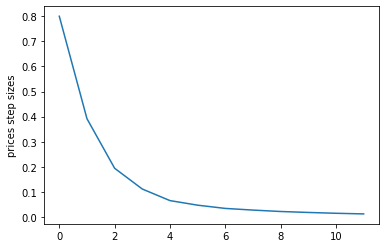

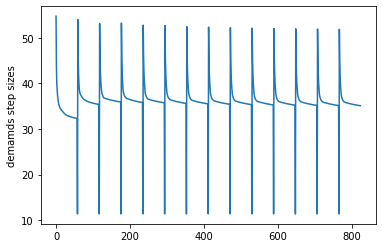

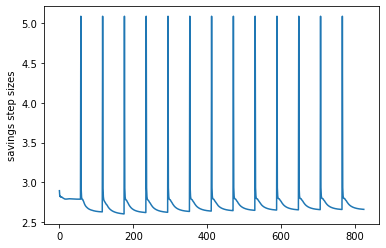

In [17]:
num_goods = 5
num_buyers = 5
num_samples = 25
discount = 0.9

valuations = np.array([[0.50722067, 0.76313337, 0.05360443, 0.7501781,  0.67800042],
 [0.2274455,  0.06174344, 0.39171342, 0.1402779,  0.15473259],
 [0.16527965, 0.3476444,  0.36241701, 0.99000073, 0.75359852],
 [0.34999164, 0.68091931, 0.0310125,  0.17069236, 0.03813618],
 [0.02829523, 0.34238797, 0.69479688, 0.45690191, 0.4699344 ]])


valuations = valuations * 5



num_iters_prices = 40
num_iters_demands = 60

value_coef = np.zeros(5)
value_intercept = 0


budgets = np.array([9.09845395, 9.18667045, 9.2, 10, 10])


utility_type = "linear"


learn_rate_prices = 1.7
learn_rate_demands = 0.02

print(learn_rate_prices)
print(learn_rate_demands)


prices_step_sizes, demands_step_sizes, savings_step_sizes = min_max_linear_value_jax(budgets, valuations, value_coef, value_intercept, 
                                                                                 discount, learn_rate_prices, learn_rate_demands, 
                                                                                num_iters_prices, num_iters_demands, utility_type, test=True)
plt.plot(prices_step_sizes[1:])
plt.ylabel("prices step sizes")
plt.show()

plt.plot(demands_step_sizes[1:])
plt.ylabel("demamds step sizes")
plt.show()

plt.plot(savings_step_sizes[1:])
plt.ylabel("savings step sizes")
plt.show()


## single_buyer_val_iter

In [18]:
def single_buyer_val_iter(budgets_samples, prices_list, buyer, valuations, gamma, slope, intercept, 
                          num_iters, num_samples, utility_type, fitted_value_coef, fitted_value_intercept):
    value_slope_hist = []
    value_intercept_hist = []
    values_hist = []
    budgets_hist = []

    if utility_type == "linear":
        get_max = get_max_linear
    elif utility_type == "leontief":
        get_max = get_max_leontief
    elif utility_type == "cd":
        get_max = get_max_cd

    value_slope = slope
    value_intercept = intercept
    value_slope_hist.append(value_slope)
    value_intercept_hist.append(value_intercept)
    num_buyers = valuations.shape[0]
    

    for iter in range(num_iters):
        print(f"-----------------------Iteration {iter}-------------------")
        values = []
        budget_list = []
        for index, budgets in enumerate(budgets_samples):
          print(f"___sample {index}___")
          value, demand, saving = get_max(budgets[buyer], valuations[buyer], prices_list[index], discount, value_slope, value_intercept)
          values.append(value)
          budget_list.append(budgets[buyer])
          print("buyer value:", value)
          print("buyer demands:", demand)

        values_hist.append(values)    
        budgets_hist.append(budget_list)
        print(budget_list)
        print(values)
        reg = linear_model.LinearRegression()
        reg.fit(np.array(budget_list).reshape(-1,1), np.array(values))
        value_slope = reg.coef_ # Update the slope
        value_intercept = reg.intercept_ # Update the intercept
        
        value_intercept_hist.append(value_intercept)
        value_slope_hist.append(value_slope)
        values_hist.append(values)
        budgets_hist.append(budgets)
        print("SLOPE", value_slope)
        print("INTERCEPT:", value_intercept)
    
    return value_slope, value_intercept, values_hist



## get_greedy_action

In [19]:
def get_greedy_action(budgets, valuations, utility_type, value_coef, value_intercept, discount, 
                                           learn_rate_prices, learn_rate_demands, num_iters_prices, num_iters_demands):
  value, prices, demands, savings =  min_max_linear_value_jax(budgets, valuations, value_coef, value_intercept, discount, learn_rate_prices, learn_rate_demands, 
                         num_iters_prices, num_iters_demands, utility_type, test=False)

  return (prices, demands, savings)

## get_buyers_cumulative_util

In [20]:
def get_buyers_cumulative_util(init_budgets, valuations, utility_type, value_coef, value_intercept, discount, learn_rate_prices, learn_rate_demands,
                               num_iters_prices, num_iters_demands, num_iters):
  
  if utility_type == "linear":
      get_util = get_linear_util
  elif utility_type == "leontief":
      get_util = get_leontief_util
  elif utility_type == "cd":
      get_util = get_cd_util
  
  num_buyers = valuations.shape[0]
  num_goods = valuations.shape[1]
  cumul_utils = np.zeros(num_buyers)
  excess_demands_hist = []
  budgets = init_budgets   
  for iter in range(num_iters):
    print(f"--------------------cumulative iter {iter}---------------------")
    print(f"budgets: {budgets}")
    prices, demands, savings = get_greedy_action(budgets, valuations, utility_type, value_coef, value_intercept, discount, 
                                           learn_rate_prices, learn_rate_demands, num_iters_prices, num_iters_demands)
    if iter == 0:
      start_prices = prices
    excess_demands = np.sum(demands, axis = 0) - np.ones(num_goods)
    excess_demands_hist.append(np.linalg.norm(excess_demands))
    print("util:", get_util(demands, valuations))
    cumul_utils += (discount**iter)*get_util(demands, valuations)
    ir = np.random.choice([0.9, 1.0, 1.1, 1.2, 1.5], 1, [0.2, 0.2, 0.2, 0.2, 0.2])
    print("interest rate:", ir)
    print("cumul util:", cumul_utils)
    budgets = ir * savings + np.ones(num_buyers) * 9.5

  return cumul_utils, excess_demands_hist


# Changes in Value Functions

## Plot

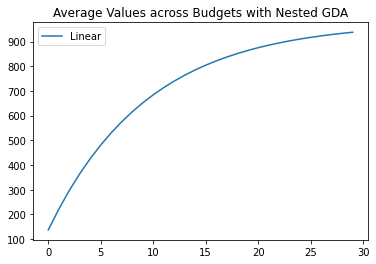

In [21]:
avg_values_linear = np.average(values_hist_linear, axis = 1) 
# avg_values_linear = avg_values_linear / np.sum(avg_values_linear)
# avg_values_leontief = np.average(values_hist_leontief, axis = 1)
# # avg_values_leontief = avg_values_leontief/ np.sum(avg_values_leontief)
# avg_values_cd = np.average(values_hist_cd, axis = 1)
# # avg_values_cd= avg_values_cd / np.sum(avg_values_cd)

fig, ax = plt.subplots()
ax.set_title('Average Values across Budgets with Nested GDA')
ax.plot(np.arange(0, avg_values_linear.shape[0]), avg_values_linear, label = "Linear")
# ax.plot(np.arange(0, avg_values_leontief.shape[0]), avg_values_leontief, label = "Leontief")
# ax.plot(np.arange(0, avg_values_cd.shape[0]), avg_values_cd, label = "Cobb-Douglas")
ax.legend()
fig.show()


# Distance to Utility Maximization

## Single_buyer_val_iter

In [41]:
discount = 0.9

slope = 0
intercept = 0

num_iters = 50
num_samples = 15
utility_type = "linear"


budgets = np.array([10,10])
fitted_value_coef = coef_hist_linear[-1]
fitted_value_intercept = intercept_hist_linear[-1]
print(fitted_value_coef)
print(fitted_value_intercept)

num_iters_prices = 60
num_iters_demands = 60


[2.3653286  1.46885294 2.5569754  2.11516402 2.00172939]
843.8263283966813


##### Get budgets-prices pairs for value iterations

In [42]:
num_buyers = valuations.shape[0]
budgets_samples = np.random.uniform(9, 10, (num_samples, num_buyers))
prices_list = []
learn_rate_prices = 1.7
learn_rate_demands = 0.02
for index, budgets in enumerate(budgets_samples):
    print(f"-------------------------Sample {index}--------------------------------")
    min_max_value, prices, demands, savings = min_max_linear_value_jax(budgets, valuations, fitted_value_coef, fitted_value_intercept, discount, 
                                                                      learn_rate_prices, learn_rate_demands,
                                                                      num_iters_prices, num_iters_demands, utility_type, test=False)
    prices_list.append(prices)

print(prices_list)

-------------------------Sample 0--------------------------------

****Min-Max Price Iteration 10****
Early end! Excess demand norm: 0.009365249909250384
------------------------------------------------------------------
budgets: [9.0962966  9.39730211 9.5528101  9.85837224 9.12474865]
demands: [[2.50162072e-01 1.73217293e-01 1.28176140e-09 2.79339802e-01
  3.27273496e-01]
 [5.26324762e-01 1.87746249e-09 4.81899863e-01 3.01736252e-09
  4.09357106e-09]
 [3.02057368e-09 2.56950638e-09 2.05975793e-09 7.15177269e-01
  3.06305274e-01]
 [2.20924007e-01 8.22263085e-01 1.39903173e-09 2.41139091e-09
  2.00002967e-09]
 [2.37299507e-09 4.18310600e-09 5.12439699e-01 1.44144068e-03
  3.62927917e-01]]
savings: [0.01019012 0.00262785 0.01650325 0.01296045 0.00353859]
prices: [ 7.23968603 10.02840992 11.58798449  9.59415545  8.73241532]
value: 946.90436
excess demands: [-0.00258915 -0.00451961 -0.00566043 -0.00404148 -0.00349331]
-------------------------Sample 1--------------------------------

****M

##### Single buyer value iteration

In [43]:
slope = 0
intercept = 0
learned_slopes = []
learned_intercepts = []
cumul_utils_single = []
values_hists = []

for buyer in range(num_buyers):
  opt_value_slope, opt_value_intercept, values_hist = single_buyer_val_iter(budgets_samples, prices_list, buyer, valuations, discount, slope, intercept, num_iters, num_samples, 
                                                                                            utility_type, fitted_value_coef, fitted_value_intercept)
  print(f"cumul util: {opt_value_slope * budgets[buyer-1] + opt_value_intercept}")
  print(f"slope: {opt_value_slope}")
  print(f"intercept: {opt_value_intercept}")
  cumul_utils_single.append(opt_value_slope * budgets[buyer-1] + opt_value_intercept)
  values_hists.append(values_hist)
  learned_slopes.append(opt_value_slope)
  learned_intercepts.append(opt_value_intercept)

Streaming output truncated to the last 5000 lines.
buyer demands: [0.         0.92565703 0.         0.         0.        ]
___sample 2___
buyer value: 3.245002406313502
buyer demands: [0.         0.95312392 0.         0.         0.        ]
___sample 3___
buyer value: 3.1247370763395277
buyer demands: [0.         0.91779952 0.         0.         0.        ]
___sample 4___
buyer value: 3.173588361129516
buyer demands: [0.         0.93214815 0.         0.         0.        ]
___sample 5___
buyer value: 3.3898186730078144
buyer demands: [0.         0.99565943 0.         0.         0.        ]
___sample 6___
buyer value: 3.1609378251129376
buyer demands: [0.         0.92843242 0.         0.         0.        ]
___sample 7___
buyer value: 3.1964842788610768
buyer demands: [0.         0.93887315 0.         0.         0.        ]
___sample 8___
buyer value: 3.1086500108501025
buyer demands: [0.         0.91307442 0.         0.         0.        ]
___sample 9___
buyer value: 3.259418215977349


##### Cumulative utils single

[36.55712591 15.73235555 48.318409   31.88111013 27.86379307]


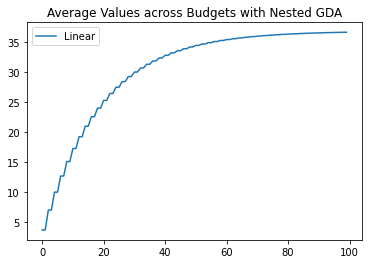

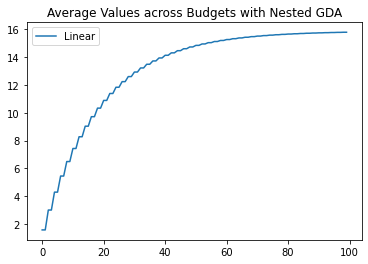

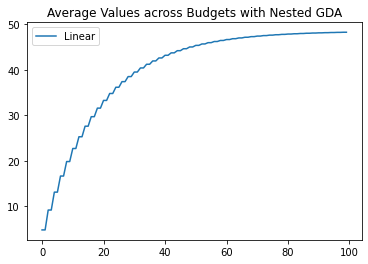

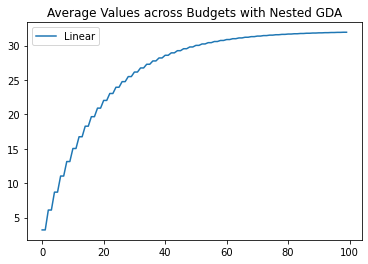

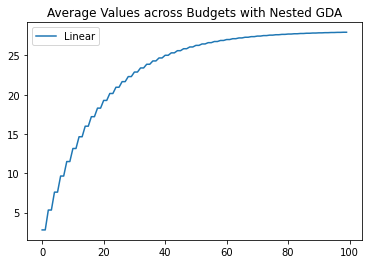

In [44]:
single_cumul_utils = np.array([util[0] for util in cumul_utils_single])
print(single_cumul_utils)

for values_hist in values_hists:
  avg_values = np.average(values_hist, axis = 1) 
# avg_values_linear = avg_values_linear / np.sum(avg_values_linear)


  fig, ax = plt.subplots()
  ax.set_title('Average Values across Budgets with Nested GDA')
  ax.plot(np.arange(0, avg_values.shape[0]), avg_values, label = "Linear")
  ax.legend()
  fig.show()

## Cumul_util all buyers

In [45]:
init_budgets = np.ones(num_buyers) * 10.0
print(fitted_value_coef)
print(fitted_value_intercept)
num_iters_prices = 60
num_iters_demands = 60
num_iters = 50
discount = 0.9
learn_rate_prices = 1.7
learn_rate_demands = 0.02
utility_type = "linear"
cumul_utils, excess_demands_hist =  get_buyers_cumulative_util(init_budgets, valuations, utility_type, fitted_value_coef, fitted_value_intercept, discount, learn_rate_prices, learn_rate_demands,
                               num_iters_prices, num_iters_demands, num_iters)

[2.3653286  1.46885294 2.5569754  2.11516402 2.00172939]
843.8263283966813
--------------------cumulative iter 0---------------------
budgets: [10. 10. 10. 10. 10.]
Early end! Excess demand norm: 0.009742192759720218
------------------------------------------------------------------
budgets: [10. 10. 10. 10. 10.]
demands: [[2.61910506e-01 1.92945600e-01 1.74516410e-08 2.81233909e-01
  3.35404526e-01]
 [5.42772656e-01 2.48997773e-08 4.76019332e-01 3.96670425e-08
  5.38806056e-08]
 [4.05195308e-08 3.44109925e-08 2.71365381e-08 7.16881878e-01
  2.90952073e-01]
 [1.88037877e-01 8.08665629e-01 1.85814890e-08 3.26165856e-08
  2.68970500e-08]
 [3.12271527e-08 5.48495836e-08 5.29558906e-01 1.41255352e-07
  3.75803130e-01]]
savings: [4.21561370e-03 9.66676802e-05 1.60494505e-02 1.80741835e-02
 4.82861384e-04]
prices: [ 7.61464983 10.57307483 12.32487397 10.17640949  9.24092336]
value: 953.05756
excess demands: [-0.00727889  0.00161134  0.0055783  -0.001884    0.00215981]
util: [3.59234789 1.549

In [46]:
print(excess_demands_hist)
print(np.mean(excess_demands_hist))

[0.009742192759720218, 0.009413870648361751, 0.009382910481381554, 0.009382997645805398, 0.00936354686880387, 0.009363725806048063, 0.009363720494963765, 0.009383143229322054, 0.009383023304549666, 0.00930517614525509, 0.009306245229748693, 0.009403151555471298, 0.009363366805217922, 0.0093637872690375, 0.009363745624998731, 0.009305446099654705, 0.009383757320102281, 0.009420584052023919, 0.009363289389460626, 0.009402612996808985, 0.009304960130890296, 0.00942130838662626, 0.009382735152005004, 0.009363540482933932, 0.00938321745628999, 0.009402505223710467, 0.009363360644528258, 0.0093831708822107, 0.00938300347548903, 0.009383036703551976, 0.00940250461309889, 0.009420500661726504, 0.009382802348413323, 0.009363550411242328, 0.009383197347048294, 0.009402515486494905, 0.00930502188672133, 0.009421241112279792, 0.009402223585191322, 0.009363338842204482, 0.009363730721078715, 0.009383183986159093, 0.009363544579690363, 0.009383196433535966, 0.00940249785378438, 0.009363335334470816,

In [48]:
print(cumul_utils)

[35.5503729  15.32819018 46.01347934 30.52137598 26.90903462]


## Results

In [49]:
print(cumul_utils)
print(single_cumul_utils)

[35.5503729  15.32819018 46.01347934 30.52137598 26.90903462]
[36.55712591 15.73235555 48.318409   31.88111013 27.86379307]


In [50]:
print(np.linalg.norm(cumul_utils-single_cumul_utils))
print(np.linalg.norm(cumul_utils-single_cumul_utils) / np.linalg.norm(single_cumul_utils))

3.0413882828995074
0.040243964757669434
